<H1><center>E-commerce Customer Churn
<br>--------
<br><center>Data Preparation

By : Fathur Rizky Maulana

### **Contents**

0. Initial Setup
1. Business Problem Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

****

### `Initial Setup`

In [2]:
# Import library eksplorasi dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Membuat grafik
import seaborn as sns #Membuat grafik
import missingno as msno #Cek missing value
import phik #Cek phik korelasi
from sklearn.experimental import enable_iterative_imputer #Melakukan imputasi
from sklearn.impute import IterativeImputer #Melakukan imputasi

# Import library uji statistics
from scipy.stats import ks_2samp # Uji KS untuk melihat distorsi sebelum dan sesudah handling outlier

# Import library modeling
import pycaret

# Setting max column
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 35)

import warnings
warnings.filterwarnings('ignore')

### `Business Problem Understanding`

**Problem Statement**

.....

**Goals**

......

**Analytic Approach**

......

**Metric Evaluation**

|           | N-Pred | P-Pred |
| --------- | ------ | ------ |
| **N-Act** |   TN   |   FP   |
| **P-Act** |   FN   |   TP   |

**Target**:   
`0` : Pelanggan tidak *churn*  
`1` : Pelanggan *churn*

**Metric Evaluation**:   
`Type 1 error` : **False Positive**   
Konsekuensi: Mengeluarkan biaya untuk pelanggan yang tidak akan churn. 

`Type 2 error` : **False Negative**   
Konsekuensi: Kehilangan pelanggan yang sebenarnya dia loyal.

Berdasarkan konsekuensinya, langkah yang tepat untuk pemilihan model adalah model yang **mengurangi jumlah hilangnya pelanggan loyal**. Jadi kita ingin sebanyak mungkin memprediksi sebanyak mungkin `kelas Positif` yang benar Positif, dan sesedikit mungkin prediksi `False Negative`. Jadi metric utama yang akan digunakan adalah Recall,

### `Data Understanding`

Dataset dan deskripsi dapat di akses pada link berikut:
<br>
[E-commerce Customer Churn](https://drive.google.com/drive/folders/1PITb78NtK9Ra6wOkQdXCIgItZkj29Ves)

| Columns                                            | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| `Tenure` | Masa tenure pelanggan |
| `WarehouseToHome` | Jarak antara warehouse ke rumah pelanggan |
| `NumberOfDeviceRegistered` | Jumlah perangkat yang terdaftar |
| `PreferedOrderCat` | Kategori yang disukai pelanggan bulan lalu |
| `SatisfactionScore` | Skor kepuasan pelanggan terhadap service |
| `MaritalStatus` | Status pernikahan pelanggan |
| `NumberOfAddress` | Jumlah alamat yang terdaftar |
| `Complain` | Adakah complain dalam satu bulan terakhir |
| `DaySinceLastOrder` | Hari sejak pemesanan terakhir |
| `CashbackAmount` | Rata-rata cashback bulan lalu |
| `Churn` | Status churn pelanggan |

**`Complain`** == `0` : Tidak Ada *complain*, `1` : ada *complain*
<br>
**`Churn`** == `0` : Tidak *churn*, `1` : *Churn*

In [3]:
# Import file CSV

df = pd.read_csv("D:\Purwadhika JCDS\Capstone Project\Modul-3\data\\raw\data_ecommerce_customer_churn.csv")
print(f'Jumlah baris dan kolom: {df.shape}')

df.sample(5)

Jumlah baris dan kolom: (3941, 11)


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
2566,2.0,8.0,4,Mobile Phone,5,Single,3,1,0.0,136.46,1
66,0.0,16.0,3,Laptop & Accessory,2,Single,1,0,1.0,149.50,0
44,NaN,7.0,4,Mobile,3,Married,2,0,0.0,120.08,0
622,22.0,14.0,4,Grocery,4,Married,7,0,NaN,231.20,0
2063,4.0,NaN,4,Mobile,4,Single,1,1,2.0,126.57,0


#### **Initial Assesment**

In [4]:
# Check karakteristik dataset

pd.DataFrame(
        {
        'feature': df.columns.values,
        'data_type': df.dtypes.values,
        'total_row': df.isna().count().values,
        'total_null': df.isna().sum().values,
        '%null_value': df.isna().mean().values * 100,
        'n_unique': df.nunique().values,
        'sample_unique': [df[col].unique() for col in df.columns]
        }
    )

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,Tenure,float64,3941,194,4.922608,36,"[15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0,..."
1,WarehouseToHome,float64,3941,169,4.288252,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0..."
2,NumberOfDeviceRegistered,int64,3941,0,0.000000,6,"[4, 3, 6, 2, 5, 1]"
3,PreferedOrderCat,object,3941,0,0.000000,6,"[Laptop & Accessory, Mobile, Fashion, Others, ..."
4,SatisfactionScore,int64,3941,0,0.000000,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,object,3941,0,0.000000,3,"[Single, Married, Divorced]"
6,NumberOfAddress,int64,3941,0,0.000000,14,"[2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]"
7,Complain,int64,3941,0,0.000000,2,"[0, 1]"
8,DaySinceLastOrder,float64,3941,213,5.404720,22,"[7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0,..."
9,CashbackAmount,float64,3941,0,0.000000,2335,"[143.32, 129.29, 168.54, 230.27, 322.17, 152.8..."


__Insight :__
<br>

**Numerical Variable:**
- `Discrete` : NumberOfDeviceRegistered, NumberOfAddress
- `Continue` : Tenure, WarehouseToHome, DaySinceLastOrder, CashbackAmount
<br>

**Categorical variable:**
- `Nominal` : PreferedOrderCat, MaritalStatus, Complain, **Churn**
- `Ordinal` : SatisfactionScore

`Target`: Churn

#### **Numerical variable**

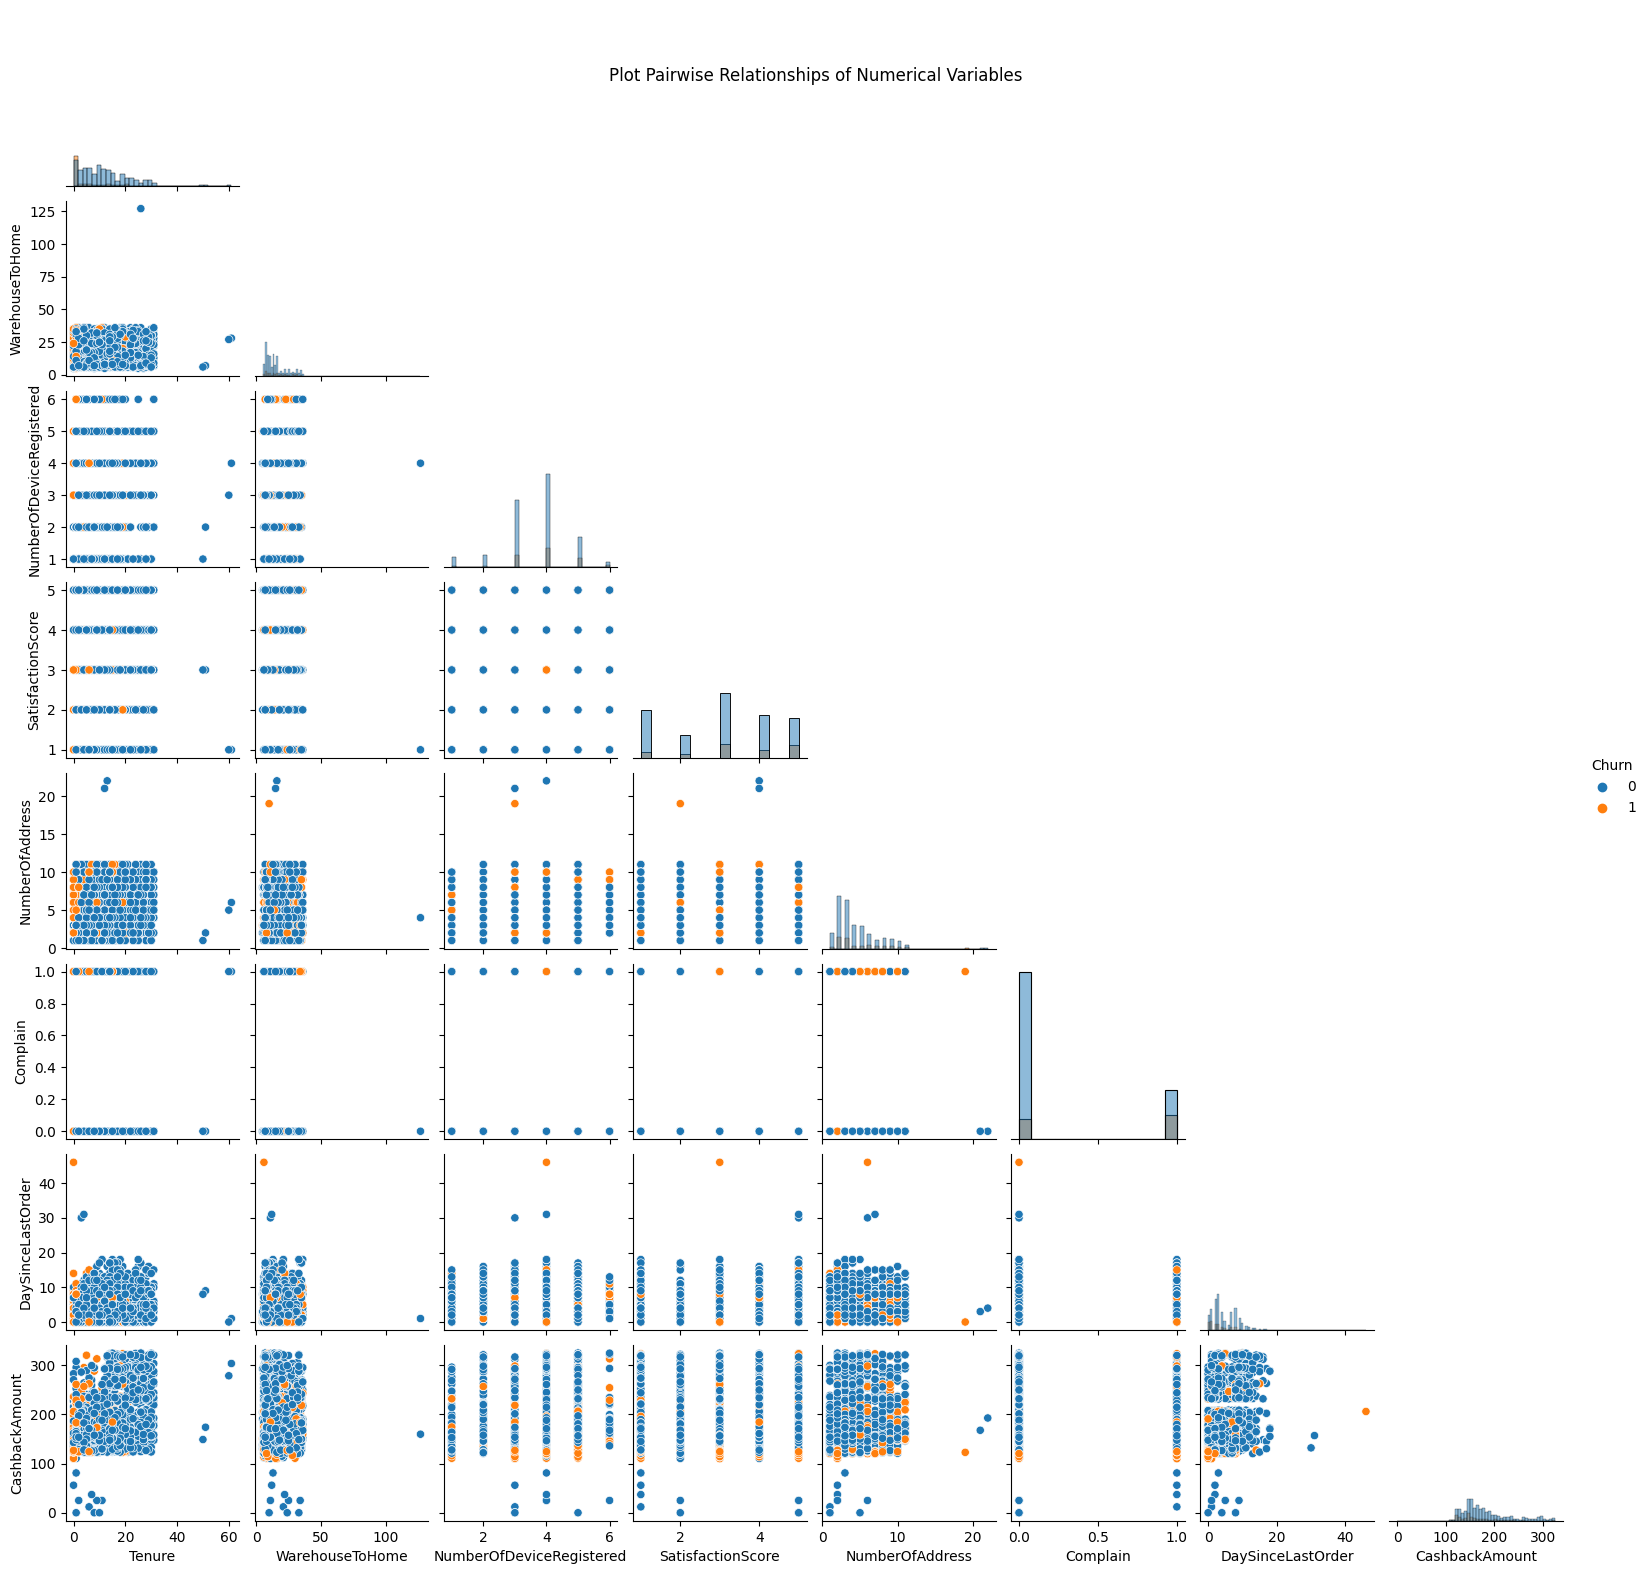

In [5]:
numerical = [var for var in df.columns if var not in [["PreferedOrderCat", "MaritalStatus"]]]

graph = sns.pairplot(df[numerical], height=2.0, corner=True, diag_kind="hist", hue="Churn")
graph.fig.suptitle("Plot Pairwise Relationships of Numerical Variables", y=0.95)
plt.show()

__Insight :__
* ...
* ...
* ...

#### **Categorical variable**

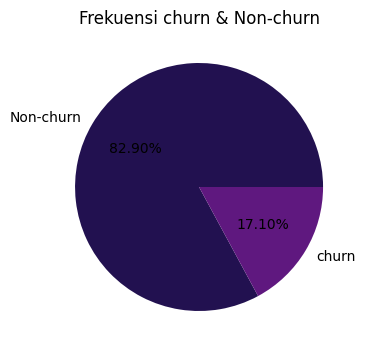

In [6]:
# Cek Categorical Variabel for Churn Feature

temp_df = df.Churn.value_counts(normalize=True) * 100

plt.subplots(figsize=(4, 5))
plt.title("Frekuensi churn & Non-churn")
plt.pie(
    x=[temp_df.loc[0], temp_df.loc[1]],
    labels=['Non-churn', 'churn'], 
    colors=sns.color_palette('magma'),
    autopct='%.2f%%'
)
plt.show()

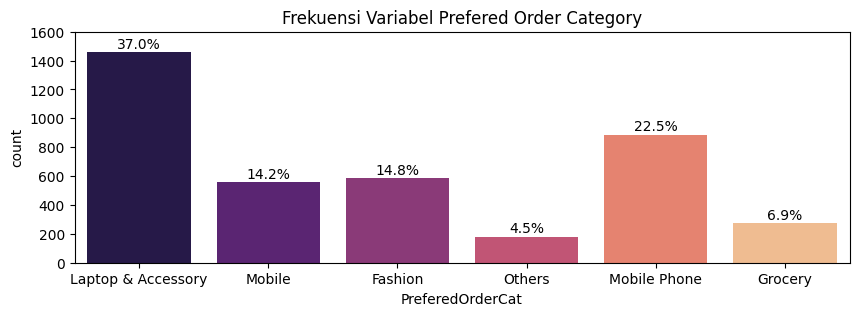

In [7]:
# Cek Categorical Variabel fo Prefered Order Category Feature

plt.subplots(figsize=(10, 3))
plt.title("Frekuensi Variabel Prefered Order Category")
ax = sns.countplot(data=df, x="PreferedOrderCat", palette="magma")
ax.set_ylim([0, 1600])

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df):.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.show()

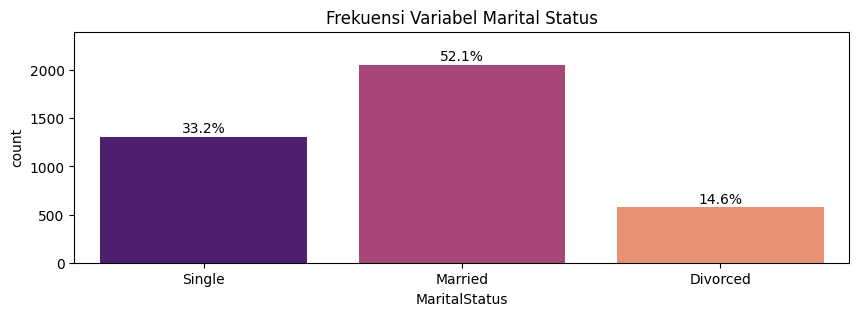

In [8]:
# Cek Categorical Variabel fo Marital Status Feature

plt.subplots(figsize=(10, 3))
plt.title("Frekuensi Variabel Marital Status")
ax = sns.countplot(data=df, x="MaritalStatus", palette="magma")
ax.set_ylim([0, 2400])

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df):.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.show()

### `Data Preparation`

In [9]:
# find the lower bound and upper bound variable

def CheckBound(x):
    Q1 = int(x.quantile([0.25]).values)
    Q3 = int(x.quantile([0.75]).values)
    IQR = Q3-Q1
    LowerBound = Q1-1.5*IQR
    UpperBound = Q3+1.5*IQR
    total = len(df[(x<LowerBound) | (x>UpperBound)])

    result = f'''
        Lower Bound is: {LowerBound}
        Upper Bound is: {UpperBound}
        Total Outlier is: {total}'''
    
    return result

#### **Finding Problematic Data**

##### **Data Duplikat dan Typo**, Deteksi dan kuantifikasi data duplikat dan kesalahan ketik:

**Data Duplikat**

In [10]:
# Cek Data Duplikat

nDuplicated = df.duplicated().sum()
DuplicatedPerc = round((df.duplicated().sum()/df.shape[0])*100,2)
print(f'Jumlah Data Duplikat: {nDuplicated}\nPersentase Data Duplikat: {DuplicatedPerc}%')

Jumlah Data Duplikat: 671
Persentase Data Duplikat: 17.03%


__Insight:__
* Terdapat 671 data duplikat dari 3.941 baris data dengan persentase sebesar 17.03%
* Dari dataset yang disajikan tidak ada variabel tipe "**ID Data**", sehingga data duplikat dapat dianggap benar-benar duplikat
* Solution : Drop data duplikat tersebut

**Data typo**

In [11]:
# Cek data typo untuk categorical variable

CategoryVar = ["PreferedOrderCat", "MaritalStatus"]
for i in CategoryVar:
    uniqueValue = df[i].unique()
    print(f"Feature {i}: {uniqueValue}")

Feature PreferedOrderCat: ['Laptop & Accessory' 'Mobile' 'Fashion' 'Others' 'Mobile Phone' 'Grocery']
Feature MaritalStatus: ['Single' 'Married' 'Divorced']


__Insight:__
* Pada feature PreferedOrderCat terdapat kategori "Mobile" dan "Mobile Phone"
* Solution : Ubah kategori "Mobile" menjadi kategori "Mobile Phone"

Handling data duplikat, dan data typo

In [12]:
# Drop data duplikat

df.drop_duplicates(inplace=True)

In [13]:
# Ubah kategori "Mobile" menjadi kategori "Mobile Phone"

df["PreferedOrderCat"].replace("Mobile", "Mobile Phone", inplace=True)

##### **Missing Value**, Deteksi dan kuantifikasi missing value:

<Axes: >

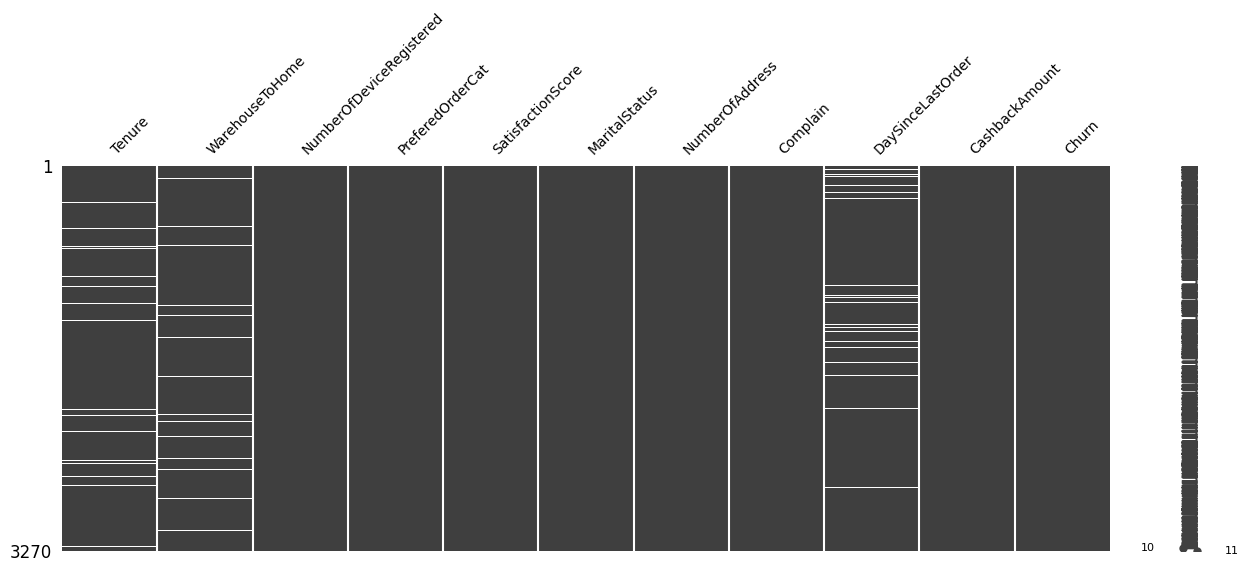

In [14]:
# Cek missing value

msno.matrix(df, figsize=(15,5), fontsize=10)

In [15]:
# Cek jumlah missing value masing-masing kolom

print(df.isna().sum())

# Kalkulasi missing value
print(f'''\nJumlah total missing value: {df.isnull().sum().sum()}
Jumlah baris yang terdapat missing value: {df[df.isnull().any(axis=1)].shape[0]}
Persentase baris dengan missing value: {round(df.isnull().sum().sum()/df.shape[0]*100,2)}%''')

Tenure                      160
WarehouseToHome             135
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           181
CashbackAmount                0
Churn                         0
dtype: int64

Jumlah total missing value: 476
Jumlah baris yang terdapat missing value: 476
Persentase baris dengan missing value: 14.56%


__Insight :__
* Terdapat tiga kolom missing value "Tenure"(160), "WarehouseToHome"(135), "DaySinceLastOrder"(182) (float64)
* Jumlah total missing value adalah 476, dan lokasi missing value di baris yang berbeda-beda (476 baris), dengan presentase missing value 14.56% dari total data tersedia
* Kita tidak bisa lakukan drop missing value (karena jumlah missing value yang cukup besar 14.56%)
* Missing value tidak menunjukan pola tertentu/ acak
* Perlu analisis lebih lanjut mengenai handling missing value

In [16]:
# Cek corelations matrix untuk kolom "Tenure", "WarehouseToHome", "DaySinceLastOrder"

# fig, ax = plt.subplots(2, 1, figsize=(15, 10))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.1)

# cols = df.columns
# corr = df[cols].phik_matrix()
# corr_mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(corr, mask=corr_mask, vmin=0, vmax=1, annot=True, cmap="YlGnBu", ax=ax[0])

# sig = df[cols].significance_matrix()
# sig_mask = np.triu(np.ones_like(sig, dtype=bool))
# sns.heatmap(sig, mask=sig_mask, annot=True, cmap="YlGnBu", ax=ax[1])

# ax[0].set_title(f"Correlation $\phi_K$")
# ax[1].set_title(f"Significance matrix")



__Insight :__
* Dari 3 kolom yang memiliki mising value ("Tenure", "WarehouseToHome", "DaySinceLastOrder"), tidak ada yang berkorelasi signifikan dengan feature lainnya
* Solution : Lakukan imputasi menggunakan metode Multivariate Imputation

Handling missing value:

In [17]:
# Membuat salinan untuk df sebelum handling missing value

df_old = df.copy()

In [18]:
# Mendapatkan index data yang missing dan tidak missing

idx_na = df[df.isna().values].index #Index missing
idx_notna = df.index.difference(idx_na) #Index tidak missing

In [19]:
# Melakukan imputasi terhadap missing value

imputasi = IterativeImputer(max_iter=10, random_state=0)
cols = ["Tenure", "WarehouseToHome", "DaySinceLastOrder"]
df[cols] = imputasi.fit_transform(df[cols])

Setelah melakukan inmputasi, kita harus uji apakah distribusi sample sebelum dilakukan handling missing value sama dengan distribusi setelah dilakukan imputasi. Uji statistik yang cocok digunakan untuk kondisi tersebut ialah uji Kolmogorov-Smirnov dua sampel.

**Hypothesis :**

`Ho` : Kedua sampel memiliki pola distribusi yang sama
<br>
`Ha` : Kedua sampel memiliki pola distribusi yang berbeda

In [20]:
# Uji KS Test 2 sample (Untuk melihat apakah terdapat perbedaan distribusi yang signifikan)

missingVal = ["Tenure", "WarehouseToHome", "DaySinceLastOrder"]

for i in missingVal:
    stats, pvalue = ks_2samp(df_old.loc[idx_notna][i], df[i], alternative='two-sided')
    print(f"{i}\np-value: {round(pvalue,4)}")
    if pvalue>0.05:
        print(f"p-value > 0.05 (significant alpha) Terima Ho\nKita punya cukup bukti bahwa kedua sample memiliki pola distribusi yang sama\n")
    else:
        print(f"p-value < 0.05 (significant alpha) Tolak Ho\nKita punya cukup bukti bahwa kedua sample memiliki pola distribusi yang berbeda\n")

Tenure
p-value: 0.2712
p-value > 0.05 (significant alpha) Terima Ho
Kita punya cukup bukti bahwa kedua sample memiliki pola distribusi yang sama

WarehouseToHome
p-value: 0.3896
p-value > 0.05 (significant alpha) Terima Ho
Kita punya cukup bukti bahwa kedua sample memiliki pola distribusi yang sama

DaySinceLastOrder
p-value: 0.0155
p-value < 0.05 (significant alpha) Tolak Ho
Kita punya cukup bukti bahwa kedua sample memiliki pola distribusi yang berbeda



__Insight :__ 
* ....
* ....
* ....

##### **Outlier,** Deteksi dan kuantifikasi outlier:

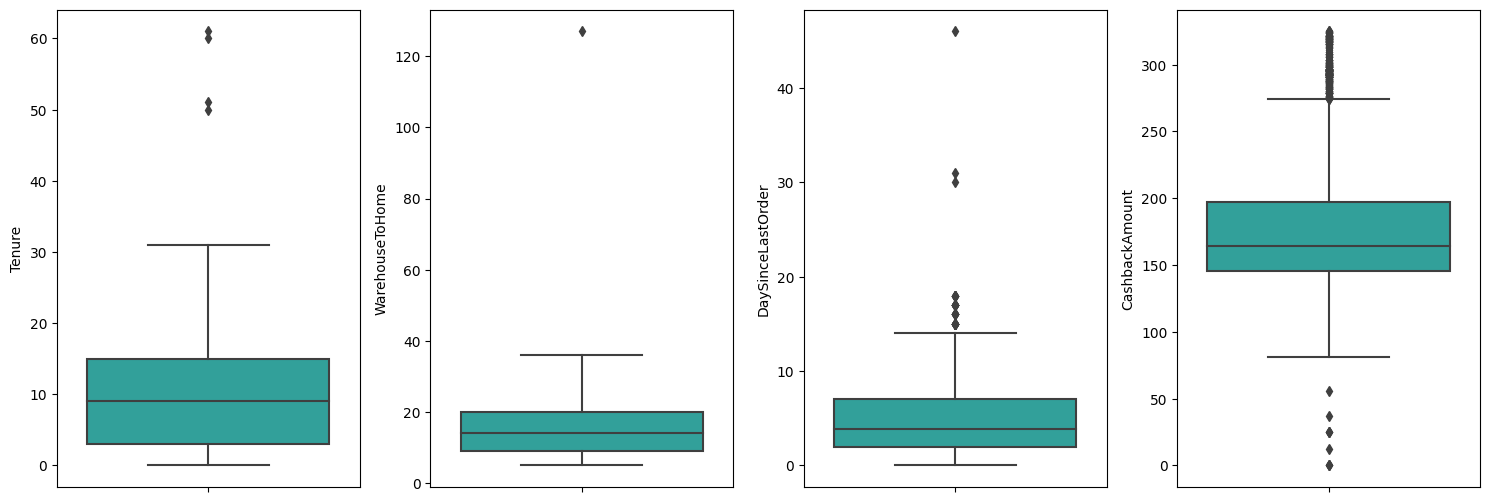

In [21]:
# Cek data outlier in continue variable (Tenure, WarehouseToHome, DaySinceLastOrder, CashbackAmount)

contVar = ["Tenure", "WarehouseToHome", "DaySinceLastOrder", "CashbackAmount"]

plt.figure(figsize=(15,20))
for i in range(0, len(contVar)):
  plt.subplot(4, 4, i+1)
  sns.boxplot(y=df[contVar[i]], color="lightseagreen", orient='v')
  plt.tight_layout()


In [22]:
# Melihat lower bound, upper bound, outlier, dan persentase outlier
for i in range(0, len(contVar)):
    Q1 = df[contVar[i]].quantile(0.25)
    Q3 = df[contVar[i]].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound =  Q1 - (1.5 * IQR)
    upper_bound =  Q3 + (1.5 * IQR)
    condition = (df[contVar[i]]< lower_bound) | (df[contVar[i]]> upper_bound)
    outlier = df.loc[condition, contVar[i]].count()
    PersentaseOutlier = outlier/df[contVar[i]].count()*100
    print(f"{contVar[i]}\nLower Bound   : {round(lower_bound,2)}\nUpper Bound   : {round(upper_bound,2)}\nJumlah Outlier: {outlier} ({round(PersentaseOutlier,2)}%)\n")

Tenure
Lower Bound   : -15.0
Upper Bound   : 33.0
Jumlah Outlier: 4 (0.12%)

WarehouseToHome
Lower Bound   : -7.5
Upper Bound   : 36.5
Jumlah Outlier: 1 (0.03%)

DaySinceLastOrder
Lower Bound   : -5.5
Upper Bound   : 14.5
Jumlah Outlier: 40 (1.22%)

CashbackAmount
Lower Bound   : 69.02
Upper Bound   : 274.0
Jumlah Outlier: 253 (7.74%)



__Insight :__
* Jumlah outlier pada kolom "Tenure" dan "WarehouseToHome" kecil yaitu 4 dan 1 baris. Solusi drop kolom
* Outlier pada kolom "DaySinceLastOrder" dan "CashbackAmount" bisa diabaikan karena diabaikan sebagai nilai yang wajar apabila memiliki nilai variansi yang tinggi
* Outlier pada kolom "DaySinceLastOrder" dan "CashbackAmount" akan diproses pada bagian preprocessing

Handling outlier:

In [23]:
# Drop baris yang terdapat outlier pada kolom "Tenure" dan "WarehouseToHome"

df.drop(df[(df.Tenure>33) | (df.WarehouseToHome>36.5)].index, inplace=True)

##### **Rare label**, Deteksi dan kuantifikasi rare value:

In [24]:
# Cek target model

(df["Churn"].value_counts(normalize=True) * 100).sort_index()

0    83.644717
1    16.355283
Name: Churn, dtype: float64

__Insight :__
* Imbalance data, perbandingan label **non-churn** (83.64%) lebih banyak dibanding label **churn** (16.35%)
* 

Handling rare value:

__Insight :__ 
* ....
* ....
* ....

In [25]:
len(df)

3265

#### **Feature Engineering**

Bagi dataset menjadi train set dan test set:

Proses scaling dan encoding:

Feature Creation:

Feature Selection:

### `Modeling`

#### **Model Experiment**

Bandingkan model regresi atau klasifikasi untuk mendapatkan benchmark model:

Lakukan optimasi model benchmark:

Validasi silang 10-fold untuk mendapatkan rentang kinerja model:

**Model Intepretation**

* .....
* .....
* .....

**Model Limitation**

* .....
* .....
* .....


### `Conclusion`

Beberapa hal yang dapat disimpulkan yaitu:

* ....
* ....
* ....

### `Recommendations`

Hal yang dapat dilakukan untuk mengembangkan model agar lebih baik lagi, seperti:

* ....
* ....
* ....